# Image segmentation Severstal data


From https://towardsdatascience.com/semantic-image-segmentation-using-fully-convolutional-networks-bf0189fa3eb8

Image segmentation data from a kaggle competition: https://www.kaggle.com/c/severstal-steel-defect-detection/overview

In [17]:
#Imports
import pandas as pd
import os
from tqdm import tqdm #progress bar in python
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

Load the data:

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
train_df.dtypes

ImageId          object
ClassId           int64
EncodedPixels    object
dtype: object

**ImageId** is the id of each picture with the jpg extention
**ClassId** id the class of defect that the steal panche have, from 1 to 4
**EncodedPixels** are the range of defective pixels in an image of the form "pixel where the defect start"[space]pixel length of the defect

In [5]:
train_df.ImageId.describe()

count              7095
unique             6666
top       ef24da2ba.jpg
freq                  3
Name: ImageId, dtype: object

### Number of images in the data:

In [6]:
train_count = 0
test_count = 0

for pic in os.listdir('data/train_images'):
    train_count += 1
for pic in os.listdir('data/test_images'):
    test_count +=1

print(f"Number of train images: {train_count}")
print(f"Number of test images: {test_count}")
print(f"Number of non-defective images in the train_images forlder: {train_count - train_df.ImageId.nunique()}")

Number of train images: 12568
Number of test images: 5506
Number of non-defective images in the train_images forlder: 5902


 ### Check images
 

In [8]:
# train data:
image_size = []
for image in tqdm(os.listdir('data/train_images')):
    img = cv2.imread("data/train_images/" + image)
    h, w, c = img.shape
    
    image_size.append((h,w,c))
#Print all unique values of size, should be only one value if all are the same
print(set(image_size))

#test data:
test_image_size = []
for image in tqdm(os.listdir('data/test_images')):
    img = cv2.imread("data/test_images/" + image)
    h, w, c = img.shape
    
    test_image_size.append((h,w,c))
#Print all unique values of size, should be only one value if all are the same
print(set(test_image_size))

  0%|          | 1/5506 [00:00<09:42,  9.45it/s]

{(256, 1600, 3)}


100%|██████████| 5506/5506 [01:21<00:00, 67.32it/s] 

{(256, 1600, 3)}


Number of images in class 1:  897 (12.64%)
Number of images in class 2:  247 (3.48%)
Number of images in class 3:  5150 (72.59%)
Number of images in class 4:  801 (11.29%)


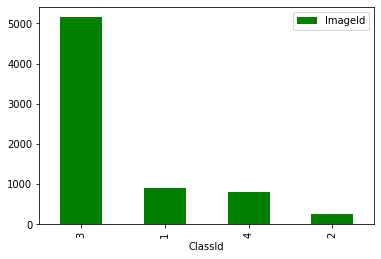

In [9]:
n_classes = train_df[['ImageId', 'ClassId']].groupby('ClassId').count().sort_values('ImageId', ascending=False)
n_classes.plot.bar(color=['green','yellow', 'red', 'blue'])
for i in range(1, 5):
    print(f"Number of images in class {i}: ", n_classes.loc[i].ImageId, f"({round((n_classes.loc[i].ImageId/n_classes.ImageId.sum())*100, 2)}%)")

Classes are inbalanced

### Data preprocessing


In [10]:
def create_df(df, directory):
    result = pd.DataFrame({"ImageId": [],"Defect_1": [],"Defect_2":[],"Defect_3":[],"Defect_4":[]})
    for image in tqdm(os.listdir(directory)):
        if image in df.ImageId.values:
            result = result.append({"ImageId":image,
                                    "Defect_1":df['EncodedPixels'][df['ImageId']==image].values[0] if df['ClassId'][df['ImageId']==image].values[0]==1 else '',
                                    "Defect_2":df['EncodedPixels'][df['ImageId']==image].values[0] if df['ClassId'][df['ImageId']==image].values[0]==2 else '',
                                    "Defect_3":df['EncodedPixels'][df['ImageId']==image].values[0] if df['ClassId'][df['ImageId']==image].values[0]==3 else '',
                                    "Defect_4":df['EncodedPixels'][df['ImageId']==image].values[0] if df['ClassId'][df['ImageId']==image].values[0]==4 else ''},
                                  ignore_index=True)

        else:
            result = result.append({"ImageId":image,"Defect_1":'',"Defect_2":'',"Defect_3":'',"Defect_4":''},
                                  ignore_index=True)
    return result


In [11]:
data = create_df(train_df, 'data/train_images')
data.head(20)

100%|██████████| 12568/12568 [01:58<00:00, 105.87it/s]


,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,f6c5aad59.jpg,,,44540 3 44790 9 45040 15 45290 21 45541 26 457...,
1,c6c4d6ba7.jpg,,,,
2,ec3e9deb2.jpg,,,,
3,c4dd4b18b.jpg,,,,
4,602f44c93.jpg,,,,
5,2d36c0d07.jpg,,,,
6,bc0a90164.jpg,,,,214 7 456 21 707 26 962 27 1217 28 1473 28 172...
7,9b63ed48c.jpg,42314 6 42570 16 42826 26 43082 36 43339 40 43...,,,
8,431af9f99.jpg,,,,
9,db8942667.jpg,,,,


In [13]:
#Split data:
train_data, cv_data = train_test_split(data, test_size=0.15, random_state=42)
print(train_data.shape, cv_data.shape)

(10682, 5) (1886, 5)


In [14]:
#Creating masks from damaged pixels:

def rle2mask(rle):
    '''
    Picture to mask creating arrays of 0 where no damage is 
    detected and 1s where there is damage. It also reduces the masks
    from 256x1600 to 128x800
    '''
    if (pd.isnull(rle))|(rle==''):
        return np.zeros((128, 800), dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape((height, width), order='F')[::2,::2]

# to convert masks to run length encoded values
def mask2rle(img):
    '''
    img: numpy array containing ones and zeros as pixel values, 1 - mask, 0 - background
    Returns String run length ecoded pixels 
    '''
    pixels= img.T.flatten() # Convert nd-array to 1d-array (numbering of pixels is from top to bottom)
    pixels = np.concatenate([[0], pixels, [0]]) # Adding zeros at the start and end so that if there's mask at the first/last pixel, it gets detected.
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 # Detect all changing pixels (where pixel values changes, either 0 -> 1 or 1 -> 0)
    
    # To get RLE, we need start pixels and run lengths
    # Start pixels are the pixels where change 0 -> 1 occurs, i.e. pixels at even indices
    # Run length is the pixel distance between two consecutive changing pixels. So, run lengths = odd indices - even indices
    runs[1::2] -= runs[::2] 

    return ' '.join(str(x) for x in runs)

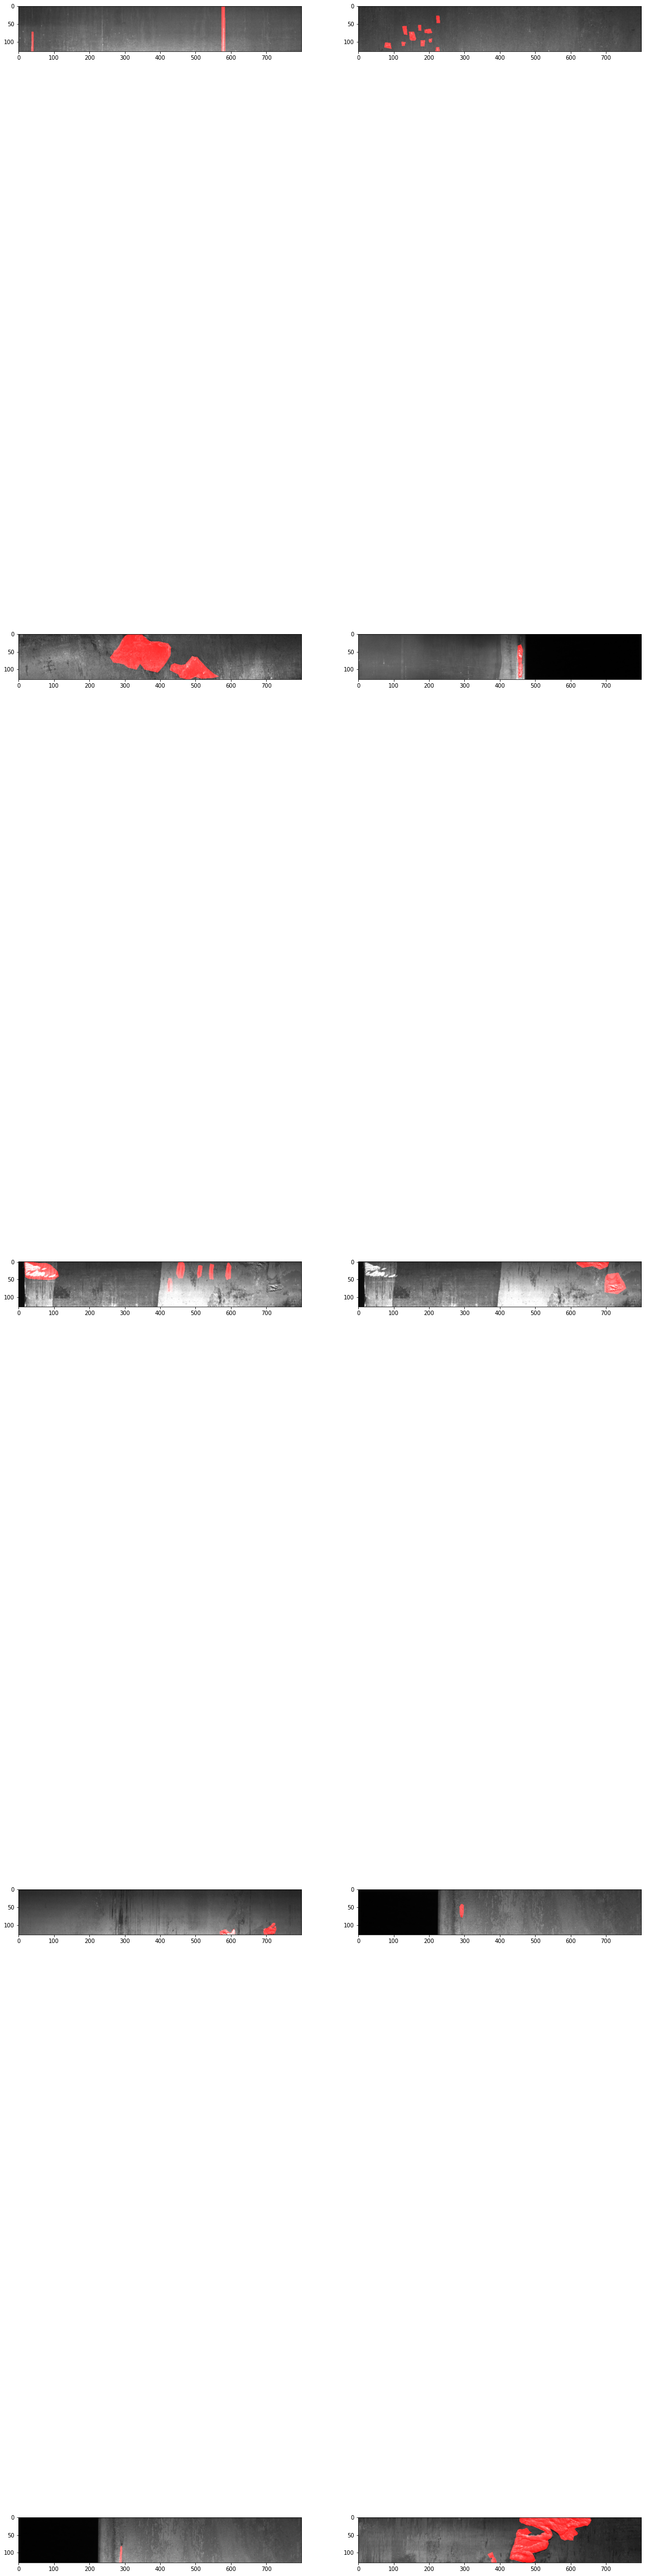

In [18]:
#Visualize some masks:

fig=plt.figure(figsize=(20,100))
columns = 2
rows = 5
for i in range(1, 10+1):
    fig.add_subplot(rows, columns, i)
    
    img = cv2.imread( 'data/train_images/'+train_df['ImageId'].iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (800,128))
    mask = rle2mask( train_df['EncodedPixels'].iloc[i])
    img[mask==1,0] = 255
    
    plt.imshow(img)
plt.show()

In [ ]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
import keras
from keras.preprocessing.image import ImageDataGenerator
class Train_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 32,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #fliping the images horizontally and normalization of samples
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
                #run-length encoding on the pixel values
            for j in range(4):
                mask = rle2mask(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

(256, 1600)

False